### Lab 5. Heuristic methods


1. Implement:

(a) Nelder-Mead method;

(b) simulated annealing method;

(c) stochastic gradient descent (SGD) method.

2. For the Nelder-Mead method, compare the trajectory and efficiency with other gradient descent methods on function Rosenbrock. Explore how the method works depending on from the choice of starting point.

3. For simulated annealing method, compare the performance with one-dimensional search methods on multimodal one-dimensional functions. Explore how the method works depending on selecting the "cooling" function.

4. For the SGD method, compare with gradient and quasi-Newton methods for the problem of finding coefficients nonlinear regression. Find the most optimal batch size for the mini-batch SGD method.

#### 1
Implement:

(a) Nelder-Mead method;

(b) simulated annealing method;

(c) stochastic gradient descent (SGD) method.


In [33]:
import numpy as np
import pandas as pd
import numba as nb
import matplotlib.pyplot as plt
import warnings
from IPython.display import Markdown
from typing import Callable
from scipy.optimize._optimize import _minimize_neldermead
from matplotlib import animation, rc

rc("animation", html="jshtml")

In [34]:
def grad(
    f: Callable[[np.ndarray], float],
    x: np.ndarray,
):
    Delta_f = np.zeros(len(x), dtype=float)
    for k in range(len(x)):
        dx = np.zeros_like(x, dtype=float)
        dx[k] = np.finfo(float).eps * 10
        Delta_f[k] = (f(x + dx) - f(x - dx)) / (2 * np.linalg.norm(dx))
    return Delta_f

In [35]:
def nelder_mead_method(
    f: Callable[[np.ndarray], float],
    start_points: list[np.ndarray],
    reflection_coef: float = 1,
    compression_coef: float = 0.5,
    stretching_coef: float = 2,
    eps: float = 1e-9,
    max_it: int = 1000,
    info: bool = False,
) -> np.ndarray:
    assert np.sum([f(p) is not None for p in start_points]) == len(start_points)
    assert len(start_points) == len(start_points[0]) + 1
    iters = 0
    calls = 0
    grad_calls = 0
    trajectory = []

    points = [p.copy() for p in start_points]
    fx = [(f(x), x) for x in points]
    calls += len(start_points)
    for k in range(max_it):
        trajectory.append([x.copy() for _fs, x in fx])
        iters += 1
        fx = sorted(fx, key=lambda val: val[0], reverse=True)
        # check convergence
        # observe dispersion:
        disp = np.std([fs for fs, _x in fx])
        if disp < eps:
            break
        # print(fx)
        f_h, x_h = fx[0]
        f_g, x_g = fx[1]
        f_l, x_l = fx[-1]
        # center of mass
        x_c = np.sum([val[1] for val in fx[1:]], axis=0) / (len(fx) - 1)
        # try reflection
        x_r = x_c + reflection_coef * (x_c - x_h)
        calls += 1
        f_r = f(x_r)
        if f_r < f_l:
            # new point is the best
            # try stretch
            x_e = x_c + stretching_coef * (x_r - x_c)
            calls += 1
            f_e = f(x_e)
            if f_e < f_r:
                # accept x_e
                # <-> x_h = x_e
                fx[0] = f_e, x_e
            else:
                # reject x_e
                # <-> x_h = x_r
                fx[0] = f_r, x_r
            continue
        elif f_l <= f_r < f_g:
            # new point is somewhat good
            # <-> x_h = x_r
            fx[0] = f_r, x_r
            continue
        else:
            assert f_r >= f_g
            # if f_g < f_r < f_h:
            #     # swap x_r, x_h
            #     x_r, x_h = x_h, x_r
            #     f_r, f_h = f_h, f_r
            #     fx[0] = f_r, x_r

            # else f_h < f_r: pass
            # print(f_l, f_g, f_h, f_r)
            # assert f_l < f_g < f_h < f_r

            # try compression
            calls += 1
            if f_r < f_h:
                x_s = x_c + compression_coef * (x_r - x_c)
                f_s = f(x_s)
                if f_s < f_r:
                    fx[0] = f_s, x_s
                    continue
            else:
                x_s = x_c + compression_coef * (x_h - x_c)
                f_s = f(x_s)
                if f_s < f_h:
                    fx[0] = f_s, x_s
                    continue
        # else
        # initial points are optimal
        # shrink the whole simplex
        points = [x_l + (x - x_l) / 2.0 for _f, x in fx[:-1]]
        calls += len(points)
        fx[:-1] = [(f(x), x) for x in points]

    trajectory.append([x.copy() for _fs, x in fx])
    if info:
        return (
            np.mean([x.copy() for _fs, x in fx], axis=0),
            iters,
            calls,
            grad_calls,
            trajectory,
        )
    else:
        return np.mean([x.copy() for _fs, x in fx], axis=0)

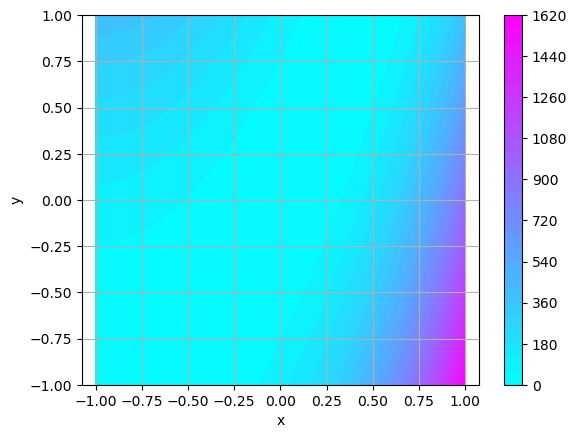

In [36]:
# rosenbrock
@nb.njit
def f_rosenbrock(x: np.ndarray) -> np.ndarray:
    # rosenbrock - shifted so that minimum at (0,0)
    # a:float=1.
    # b:float=100.
    # assert len(x.shape) == 1
    # assert x.shape[0] == 2
    # yp = x[1]+a**2
    # xp = x[0]+a
    # return (a - xp) ** 2 + b * (yp - xp ** 2) ** 2
    return (x[0]) ** 2 + 100.0 * ((x[1] + 1.0) - (x[0] + 1.0) ** 2) ** 2


def test_f_c():
    x = np.linspace(-1, 1, 100)
    y = np.linspace(-1, 1, 100)
    xr, yr = np.meshgrid(x, y)
    z = 0 * xr * yr
    for qx, xp in enumerate(x):
        for qy, yp in enumerate(y):
            p = np.array([xp, yp])
            z[qy, qx] = f_rosenbrock(p)

    plt.contourf(x, y, z, levels=30, cmap="cool")
    plt.grid()
    plt.axis("equal")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.colorbar()
    plt.show()


test_f_c()

In [37]:
def test_nelder_mead():
    x0 = [(0, -2), (1, 0), (0, 1)]
    x0 = [np.array(x) for x in x0]
    nm_scipy = _minimize_neldermead(
        func=f_rosenbrock, x0=x0[1], initial_simplex=x0, return_all=True
    )
    # print(trajectory)
    # print(nm_scipy)
    nm, iters, calls, grad_calls, trajectory = nelder_mead_method(
        f_rosenbrock, x0, eps=1e-9, info=True
    )
    # print(nm_scipy.x, nm)
    assert np.allclose(nm, nm_scipy.x, atol=1e-5)
    x, y, c = [], [], []
    for idx, points_tuple in enumerate(trajectory):
        k = [0, 1, 2]
        x.append([points_tuple[q][0] for q in k])
        y.append([points_tuple[q][1] for q in k])
        c.append(
            [
                ((idx / len(trajectory) + np.random.random(1) / 100000) ** 0.25) / 1.1
                for q in range(len(x))
            ]
        )

    fig, ax = plt.subplots()
    ax: plt.Axes = ax

    xl = np.linspace(-1, 1, 100)
    yl = np.linspace(-1, 1, 100)
    xr, yr = np.meshgrid(xl, yl)
    z = 0 * xr * yr
    for qx, xp in enumerate(xl):
        for qy, yp in enumerate(yl):
            p = np.array([xp, yp])
            z[qy, qx] = f_rosenbrock(p)

    m = ax.contourf(xl, yl, z, levels=30, cmap="cool")
    ax.grid()
    ax.axis("equal")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    fig.colorbar(m)

    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    points = ax.scatter([], [], color="red", s=4)
    (polygon,) = ax.fill([], [], facecolor=(0.1, 0.8, 0.1), alpha=0.5)

    def init():
        return (points, polygon)

    def animate(i: int):
        points.set_offsets(np.array([x[i], y[i]]).T)
        if i % 10 == 1:
            print(f"{i}/{len(x)}")
        polygon.set_xy(np.array([x[i], y[i]]).T)
        return (points, polygon)

    anim = animation.FuncAnimation(
        fig, animate, init_func=init, frames=list(range(len(x))), interval=30, blit=True
    )

    plt.close()
    return anim


test_nelder_mead()

1/69
11/69
21/69
31/69
41/69
51/69
61/69


In [38]:
def simulated_annealing_method(
    f: Callable[[float], float],
    x0: float,
    neighbour: Callable[[float], float],
    acceptance_probability_f: Callable[[float, float, float], float],
    temperature: Callable[[float], float],
    max_it: int = 1000,
    info: bool = False,
) -> float:
    iters = 0
    calls = 0
    trajectory = []
    x = x0
    f_x = f(x)
    calls += 1
    best_f = np.inf
    best_x = x
    for k in range(max_it):
        iters += 1
        calls += 1
        trajectory.append(x)

        if best_f > f_x:
            best_x = x
        T = temperature(1 - (k + 1) / max_it)
        s = neighbour(x)
        f_s = f(s)
        if acceptance_probability_f(f_x, f_s, T) > np.random.random():
            x = s
            f_x = f_s
    trajectory.append(x)
    if info:
        return (
            best_x,
            iters,
            calls,
            trajectory,
        )
    else:
        return best_x

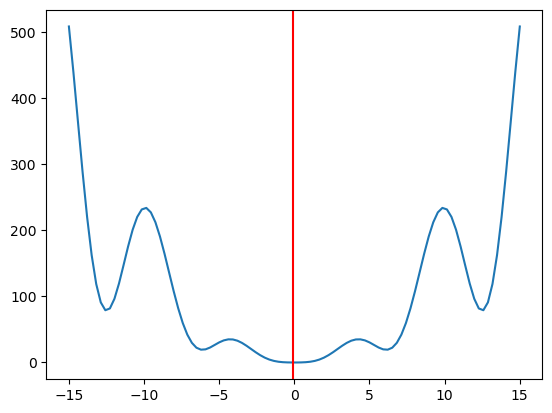

In [39]:
def test_simulated_annealing():
    def test_f(x):
        return x**2 * (1.5 - np.cos(x))

    x = np.linspace(-15, 15, 100)
    plt.plot(x, test_f(x))
    res, iters, calls, trajectory = simulated_annealing_method(
        test_f,
        15,
        lambda x: np.random.normal() * 10 + x,
        lambda f_x, f_s, T: np.exp((f_x - f_s) / T),
        lambda q: q + 0.0001,
        info=True,
    )
    # print(res)
    plt.axvline(res, color="red")
    plt.show()


test_simulated_annealing()

In [40]:
def sgd(
    f: Callable[[float, np.ndarray], float],
    p0: np.ndarray,
    x: np.ndarray,
    y: np.ndarray,
    batch_size: int,
    lr: float = 0.001,
    # eps: float = 1e-9,
    max_it: int = 1000,
    info: bool = False,
) -> np.ndarray:
    assert 0 < batch_size <= len(x)
    iters = 0
    calls = 0
    grad_calls = 0
    trajectory = []
    p = p0

    for k in range(max_it):
        iters += 1
        trajectory.append(p.copy())
        idxs = list(range(len(x)))
        np.random.shuffle(idxs)
        idxs = idxs[:batch_size]
        diff = np.zeros_like(p, dtype=float)
        for idx in idxs:

            def fp(p):
                nonlocal calls
                calls += 1
                return np.abs(y[idx] - f(x[idx], p))

            # print(p,x[idx],y[idx],fp(p))
            diff += grad(fp, p)
            grad_calls += 1
        # print(diff)
        p -= lr * diff / len(idxs)
    trajectory.append(p.copy())
    if info:
        return (
            p,
            iters,
            calls,
            grad_calls,
            trajectory,
        )
    else:
        return p

In [41]:
def test_sgd():
    def f(x: float, k):
        assert len(k.shape) == 1
        assert k.shape[0] == 1
        return np.abs(x) * k[0]

    x = np.linspace(-100, 100, 10)
    # print(f(x,np.array([1.1])))
    y = f(x, np.array([2.0])) + np.random.random(x.shape)
    print(sgd(f, np.array([1.0]), x, y, batch_size=10))

    def f(x: float, k):
        assert len(k.shape) == 1
        assert k.shape[0] == 2
        return (np.abs(x) * k[0]) + 10 * k[1]

    x = np.linspace(-100, 100, 11)
    # print(f(x,np.array([1.1])))
    y = f(x, np.array([2.0, 1.5])) + np.random.random(x.shape)
    print(sgd(f, np.array([1.0, 2.0]), x, y, batch_size=2))


test_sgd()

[1.9832]
[1.9984 1.5332]


#### 2
For the Nelder-Mead method, compare the trajectory and efficiency with other gradient descent methods on function Rosenbrock. Explore how the method works depending on from the choice of starting point.


In [42]:
def gd_constant_step(
    f: Callable[[np.ndarray], np.ndarray],
    x0: np.ndarray,
    lr: float = 0.01,
    maxit: int = 1000,
    eps: float = 1e-9,
    info=False,
) -> np.ndarray:
    iters = 0
    calls = 0
    grad_calls = 0
    trajectory = []

    x = x0
    for _ in range(maxit):
        if np.linalg.norm(x) < eps:
            break

        trajectory.append(x.copy())
        iters += 1
        grad_calls += 1

        x -= lr * grad(f, x)

    trajectory.append(x.copy())
    if info:
        return x, iters, calls, grad_calls, trajectory
    else:
        return x

In [43]:
def brent_search(f: Callable[[float], float], a: float, b: float, eps=1e-9, info=False):
    iter_count, f_call_count = 1, 1
    if b < a:
        a, b = b, a
    K = (3 - 5**0.5) / 2
    x = w = v = (a + b) / 2
    fw = fv = fx = f(x)
    deltax = 0.0
    iter = 0
    maxiter = 1e9
    while iter < maxiter:
        iter += 1
        iter_count += 1

        mintol = eps / 4
        tol1 = eps * np.abs(x) + mintol
        tol2 = 2.0 * tol1
        xmid = 0.5 * (a + b)
        # check for convergence
        if np.abs(x - xmid) < (tol2 - 0.5 * (b - a)):
            break
        if np.abs(deltax) <= tol1:
            if x >= xmid:
                deltax = a - x  # do a golden section step
            else:
                deltax = b - x
            rat = K * deltax
        else:  # do a parabolic step
            tmp1 = (x - w) * (fx - fv)
            tmp2 = (x - v) * (fx - fw)
            p = (x - v) * tmp2 - (x - w) * tmp1
            tmp2 = 2.0 * (tmp2 - tmp1)
            if tmp2 > 0.0:
                p = -p
            tmp2 = np.abs(tmp2)
            dx_temp = deltax
            deltax = rat
            # determine whether a parabolic step is acceptable or not:
            if (
                (p > tmp2 * (a - x))
                and (p < tmp2 * (b - x))
                and (np.abs(p) < np.abs(0.5 * tmp2 * dx_temp))
            ):
                # whew, parabolic fit:
                rat = p * 1.0 / tmp2
                u = x + rat
                if (u - a) < tol2 or (b - u) < tol2:
                    if xmid - x >= 0:
                        rat = tol1
                    else:
                        rat = -tol1
            else:
                # nope, try golden section instead
                if x >= xmid:
                    deltax = a - x
                else:
                    deltax = b - x
                rat = K * deltax
        # update current position:
        if np.abs(rat) < tol1:  # update by at least tol1
            if rat >= 0:
                u = x + tol1
            else:
                u = x - tol1
        else:
            u = x + rat
        fu = f(u)
        f_call_count += 1
        if fu > fx:
            # Oh dear, point u is worse than what we have already,
            # even so it *must* be better than one of our endpoints:
            if u < x:
                a = u
            else:
                b = u

            if (fu <= fw) or (w == x):
                # however it is at least second best:
                v = w
                w = u
                fv = fw
                fw = fu
            elif (fu <= fv) or (v == x) or (v == w):
                # third best:
                v = u
                fv = fu
        else:
            # good new point is an improvement!
            # update brackets:
            if u >= x:
                a = x
            else:
                b = x
            # update control points:
            v = w
            w = x
            x = u
            fv = fw
            fw = fx
            fx = fu
    res = x
    if not info:
        return res
    else:
        return res, iter_count, f_call_count, b - a

In [44]:
def golden_section_search(
    f: Callable[[float], float], a: float, b: float, eps=1e-9, info=False
):
    iter_count, f_call_count = 0, 0
    if b < a:
        a, b = b, a
    # golden ratio
    gr = (5**0.5 - 1) / 2

    iter_count += 1
    f_call_count += 2
    x = b - (b - a) * gr
    y = a + (b - a) * gr
    fx = f(x)
    fy = f(y)
    while b - a > eps:
        iter_count += 1
        f_call_count += 1
        if fx < fy:
            b = y
            y = x
            fy = fx
            x = b - (b - a) * gr
            fx = f(x)
        else:
            a = x
            x = y
            fx = fy
            y = a + (b - a) * gr
            fy = f(y)

    res = (b + a) / 2
    if not info:
        return res
    else:
        return res, iter_count, f_call_count, b - a

In [45]:
def conjugate_gradient(
    f: Callable[[np.ndarray], np.ndarray],
    x0: np.ndarray,
    max_lr: float = 0.1,
    method: str = "golden_section",
    max_it: int = 1000,
    eps: float = np.finfo(float).eps * 10,
    max_subit: int = None,
    info: bool = False,
) -> np.ndarray:
    """golden_section search or brent_search"""
    iters = 0
    calls = 0
    grad_calls = 0
    trajectory = []

    if max_subit is None:
        max_subit = len(x0)
    if method == "golden_section":
        search_method = golden_section_search
    else:
        search_method = brent_search
    x = x0
    for _ in range(max_it):
        if np.linalg.norm(x) < eps:
            break
        grad_calls += 1
        g = grad(f, x)
        r0 = -g
        d = r0
        for k in range(max_subit):
            if np.linalg.norm(x) < eps:
                break

            lr, iter_count, f_call_count, unsertainty = search_method(
                lambda y: f(x + y * d), 0, max_lr, eps=eps, info=True
            )
            iters += 1
            calls += f_call_count
            grad_calls += 1
            trajectory.append(x.copy())

            x += lr * d
            r1 = -grad(f, x)
            # Polak-Ribiere
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                beta = r1.T @ (r1 - r0) / (r0.T @ r0)
            if np.isnan(beta):
                beta = 0.0
            beta = max(beta, 0.0)
            d = r1 + beta * d
            r0 = r1

    trajectory.append(x.copy())
    if info:
        return x, iters, calls, grad_calls, trajectory
    else:
        return x

Rosenbrock

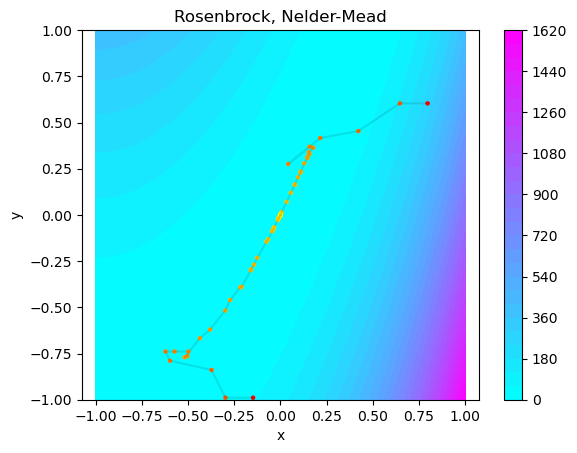

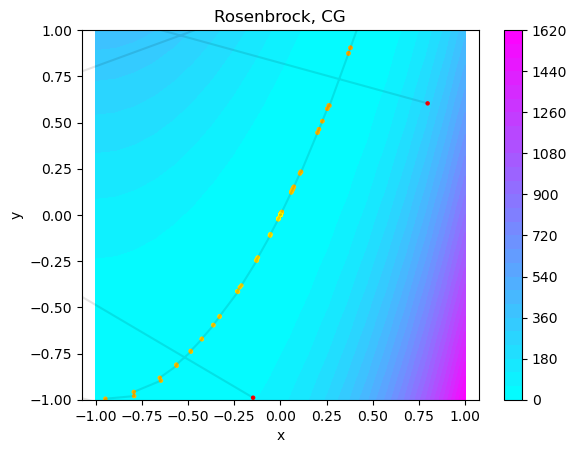

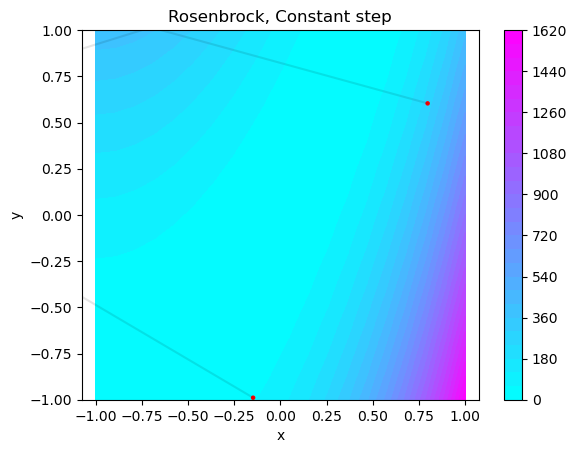

eps  Nelder-Mead (accuracy)  Nelder-Mead (iters)  \
0   1.000000e-01                0.631538                    9   
1   3.359818e-02                0.441489                   11   
2   1.128838e-02                0.285507                   15   
3   3.792690e-03                0.235052                   16   
4   1.274275e-03                0.047534                   22   
5   4.281332e-04                0.016565                   23   
6   1.438450e-04                0.016565                   23   
7   4.832930e-05                0.009656                   28   
8   1.623777e-05                0.002705                   29   
9   5.455595e-06                0.000944                   31   
10  1.832981e-06                0.000296                   31   
11  6.158482e-07                0.000467                   36   
12  2.069138e-07                0.000260                   37   
13  6.951928e-08                0.000237                   38   
14  2.335721e-08                0.000065                   42   
15  7.847600e-09                0.000065                   42   
16  2.636651e-09                0.000010                   44   
17  8.858668e-10                0.000005                   46   
18  2.976351e-10                0.000004                   49   
19  1.000000e-10                0.000008                   50   

    Nelder-Mead (calls)  Nelder-Mead (grads)  CG (accuracy)  CG (iters)  \
0                    18                    0   1.200695e+07        2000   
1                    22                    0   1.087889e+06        2000   
2                    29                    0   6.169709e+02        2000   
3                    30                    0   1.542493e+06        2000   
4                    41                    0   3.748911e+02        1072   
5                    44                    0   3.958893e-04         292   
6                    44                    0   6.500274e-05          99   
7                    54                    0   1.696318e-05          80   
8                    56                    0   2.775758e-07          78   
9                    59                    0   1.865773e-06          91   
10                   60                    0   1.642196e-06         162   
11                   68                    0   5.412946e-07         123   
12                   71                    0   9.521683e-08         127   
13                   73                    0   6.461296e-08         186   
14                   80                    0   1.012697e-08         127   
15                   80                    0   3.018617e-09         164   
16                   85                    0   1.940648e-11          94   
17                   88                    0   8.519155e-12         128   
18                   93                    0   1.786646e-10         180   
19                   96                    0   1.199716e-12         103   

    CG (calls)  CG (grads)  Constant step (accuracy)  Constant step (iters)  \
0         4000        3000               1623.709401                   1000   
1        10000        3000               1623.709401                   1000   
2        14000        3000               1623.709401                   1000   
3        18000        3000               1623.709401                   1000   
4        12864        1608               1623.709401                   1000   
5         4088         438               1623.709401                   1000   
6         1584         148               1623.709401                   1000   
7         1440         120               1623.709401                   1000   
8         1638         117               1623.709401                   1000   
9         2093         136               1623.709401                   1000   
10        4050         243               1623.709401                   1000   
11        3321         184               1623.709401                   1000   
12        3810         190               162

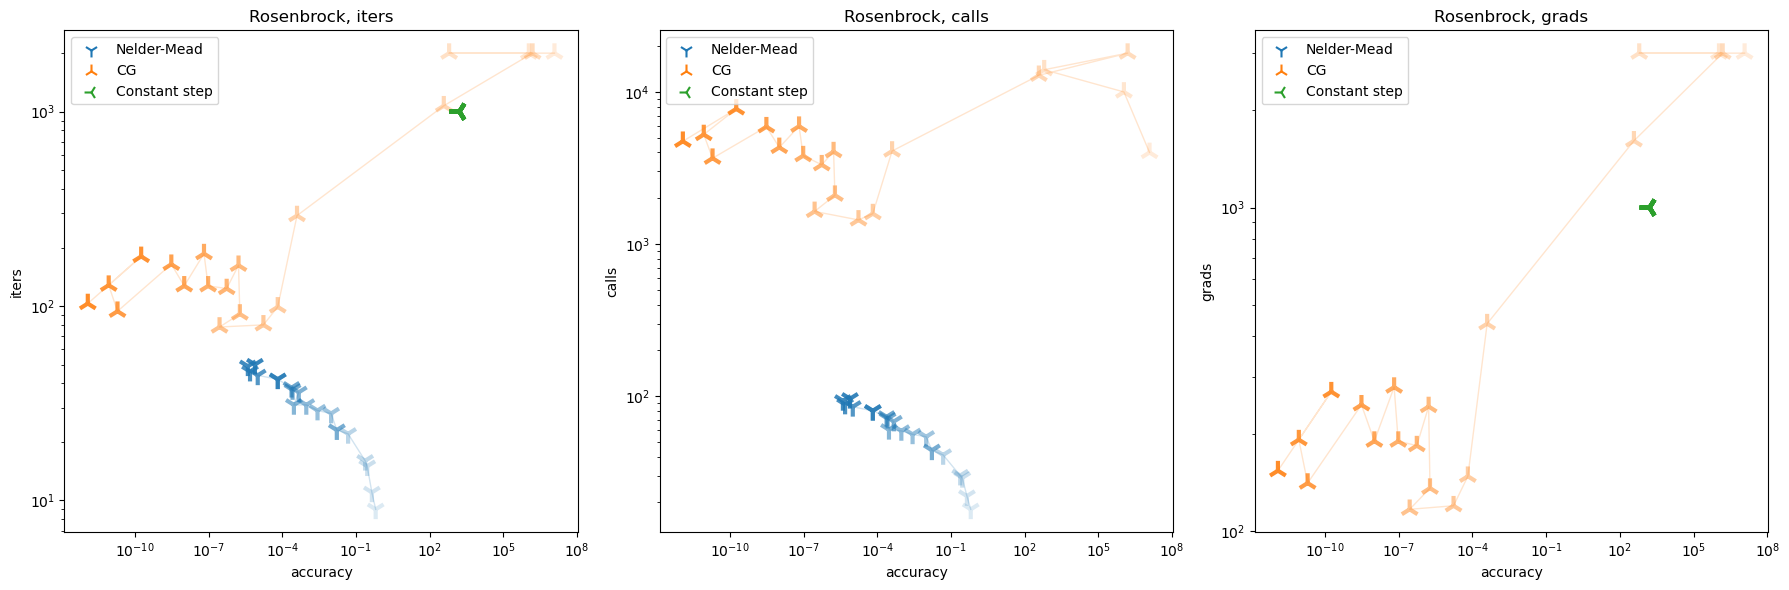

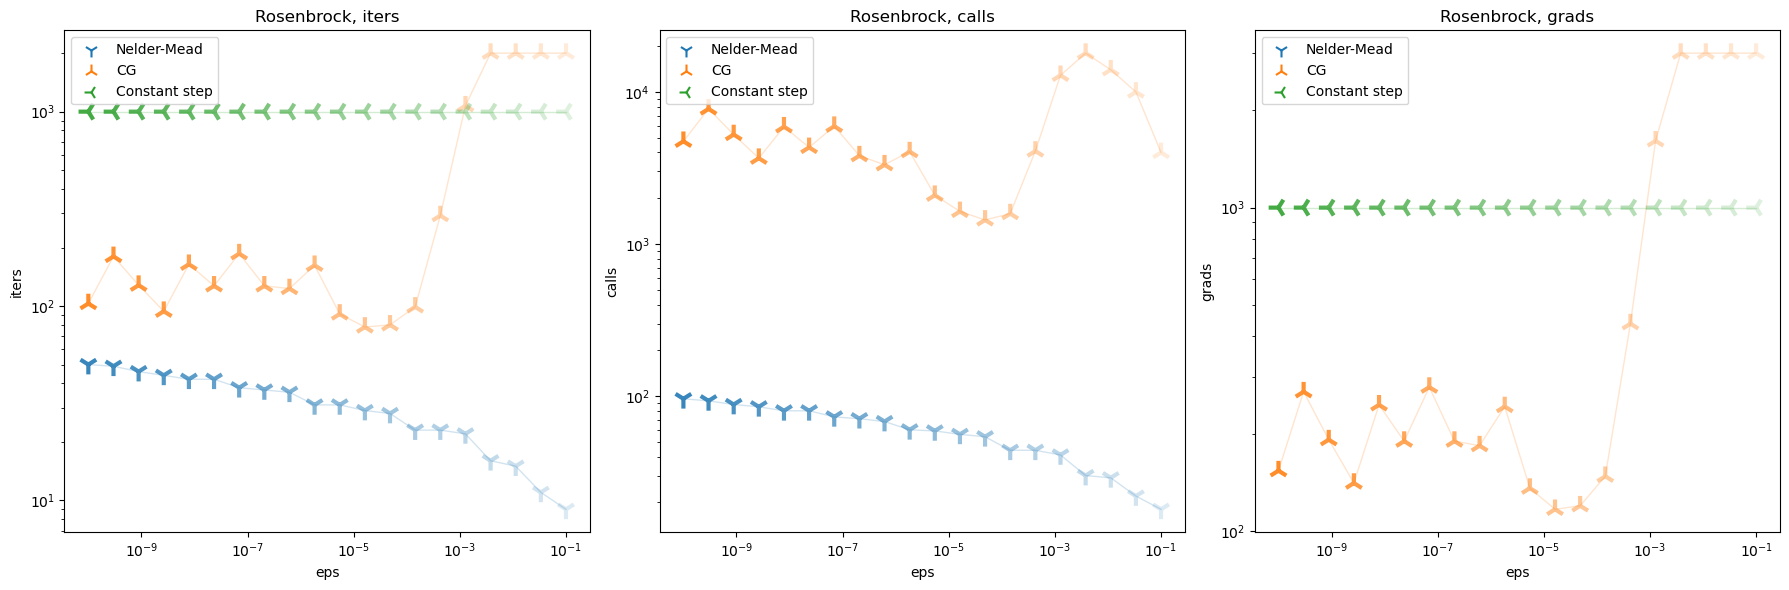

In [46]:
functions = [
    (f_rosenbrock, r"Rosenbrock"),
]
methods = [
    (nelder_mead_method, "Nelder-Mead"),
    (conjugate_gradient, "CG"),
    (gd_constant_step, "Constant step"),
]


def make_tables(
    functions: list[tuple[Callable, str]],
    methods: list[tuple[Callable, str]],
    contour: bool = False,
    plot_tables: bool = False,
):
    num_of_random_points = 2
    radius = 1
    n_countour_points = 20
    levels = 30
    EPS = np.logspace(-1, -10, 20)
    xlim = [-1, 1]
    ylim = [-1, 1]
    random_points = [
        np.array(
            [
                np.cos(random_alpha * 2 * np.pi) * radius + (xlim[1] + xlim[0]) / 2,
                np.sin(random_alpha * 2 * np.pi) * radius + (ylim[1] + ylim[0]) / 2,
            ]
        )
        for random_alpha in np.random.random(num_of_random_points)
    ]

    for f, f_name in functions:
        print()
        print()
        display(Markdown(f_name))
        data = dict()
        data["eps"] = EPS
        for method, method_name in methods:

            def plot_contours():
                plt.title(f_name + ", " + method_name)
                plt.xlabel("x")
                plt.ylabel("y")
                xl = np.linspace(xlim[0], xlim[1], n_countour_points)
                yl = np.linspace(ylim[0], ylim[1], n_countour_points)
                x, y = np.meshgrid(xl, yl)
                z = 0 * x * y
                for qx, xp in enumerate(xl):
                    for qy, yp in enumerate(yl):
                        p = np.array([xp, yp])
                        # print(p)
                        z[qy, qx] = f(p)
                # plt.grid()
                plt.axis("equal")
                if contour:
                    plt.contour(x, y, z, levels=levels, cmap="cool")
                else:
                    plt.contourf(x, y, z, levels=levels, cmap="cool")
                plt.colorbar()

            plot_contours()
            acc_total, iters_total, calls_total, grad_total = [], [], [], []
            for ideps, eps in enumerate(EPS):
                acc_multipoint, iters_multipoint, calls_multipoint, grad_multipoint = (
                    [],
                    [],
                    [],
                    [],
                )
                for point in random_points:
                    # solve
                    p = point.copy()
                    if method_name == "Nelder-Mead":
                        initial_simplex = [
                            p + np.array([0.1, 0.0]),
                            p + np.array([0.0, 0.1]),
                            p + np.array([-0.1, -0.1]),
                        ]
                        result, iters, calls, grad_calls, trajectory = method(
                            f, initial_simplex, eps=eps, info=True
                        )
                        trajectory = [np.mean(t, axis=0) for t in trajectory]
                    else:
                        result, iters, calls, grad_calls, trajectory = method(
                            f, p, eps=eps, info=True
                        )

                    if ideps + 1 == len(EPS):
                        trajectory = np.array(trajectory)
                        x, y = trajectory.T[0], trajectory.T[1]
                        # print(x[0],y[0])
                        x, y = x, y
                        c = [(q / len(x)) ** 0.25 for q in range(len(x))]
                        plt.plot(x, y, color="black", alpha=0.1)
                        plt.scatter(x, y, s=5, c=c, cmap="autumn")
                    acc_multipoint.append(
                        np.linalg.norm(result - np.zeros_like(result))
                    )
                    iters_multipoint.append(iters)
                    calls_multipoint.append(calls)
                    grad_multipoint.append(grad_calls)
                acc_total.append(np.mean(acc_multipoint))
                iters_total.append(int(np.mean(iters_multipoint)))
                calls_total.append(int(np.mean(calls_multipoint)))
                grad_total.append(int(np.mean(grad_multipoint)))
            plt.xlim(xlim)
            plt.ylim(ylim)
            plt.show()
            data[method_name + " (accuracy)"] = acc_total
            data[method_name + " (iters)"] = iters_total
            data[method_name + " (calls)"] = calls_total
            data[method_name + " (grads)"] = grad_total
        data = pd.DataFrame(data)
        display(data)
        if plot_tables:
            # accuracy
            plt.figure(figsize=(18, 6))
            for plot_idx, plot_type in enumerate(["iters", "calls", "grads"]):
                plt.subplot(1, 3, plot_idx + 1)
                plt.title(f_name + ", " + plot_type)
                for method_id, (method, method_name) in enumerate(methods):
                    alpha = [
                        (0.2 + idx / len(data[method_name + f" ({plot_type})"])) / 1.3
                        for idx, d in enumerate(data[method_name + f" ({plot_type})"])
                    ]
                    (c,) = plt.plot([], [])
                    c = c.get_color()
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore")
                        plt.scatter(
                            [],
                            [],
                            label=method_name,
                            marker=str(method_id + 1),
                            s=100,
                            c=c,
                        )
                        plt.scatter(
                            data[method_name + " (accuracy)"],
                            data[method_name + f" ({plot_type})"],
                            marker=str(method_id + 1),
                            alpha=alpha,
                            s=200,
                            c=c,
                            lw=3,
                        )
                        plt.plot(
                            data[method_name + " (accuracy)"],
                            data[method_name + f" ({plot_type})"],
                            alpha=0.2,
                            c=c,
                            lw=1,
                        )
                        plt.xscale("log")
                        plt.yscale("log")
                plt.xlabel("accuracy")
                plt.ylabel(plot_type)
                plt.legend()
            plt.tight_layout()
            plt.show()
            # eps
            plt.figure(figsize=(18, 6))
            for plot_idx, plot_type in enumerate(["iters", "calls", "grads"]):
                plt.subplot(1, 3, plot_idx + 1)
                plt.title(f_name + ", " + plot_type)
                for method_id, (method, method_name) in enumerate(methods):
                    alpha = [
                        (0.2 + idx / len(data[method_name + f" ({plot_type})"])) / 1.3
                        for idx, d in enumerate(data[method_name + f" ({plot_type})"])
                    ]
                    (c,) = plt.plot([], [])
                    c = c.get_color()
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore")
                        plt.scatter(
                            [],
                            [],
                            label=method_name,
                            marker=str(method_id + 1),
                            s=100,
                            c=c,
                        )
                        plt.scatter(
                            data["eps"],
                            data[method_name + f" ({plot_type})"],
                            marker=str(method_id + 1),
                            alpha=alpha,
                            s=200,
                            c=c,
                            lw=3,
                        )
                        plt.plot(
                            data["eps"],
                            data[method_name + f" ({plot_type})"],
                            alpha=0.2,
                            c=c,
                            lw=1,
                        )
                        plt.xscale("log")
                        plt.yscale("log")
                plt.xlabel("eps")
                plt.ylabel(plot_type)
                plt.legend()
            plt.tight_layout()
            plt.show()
            # eps vs accuracy
            plt.figure(figsize=(18, 6))
            for plot_idx, plot_type in enumerate(["accuracy"]):
                plt.subplot(1, 3, plot_idx + 1)
                plt.title(f_name + ", " + plot_type)
                for method_id, (method, method_name) in enumerate(methods):
                    alpha = [
                        (0.2 + idx / len(data[method_name + f" ({plot_type})"])) / 1.3
                        for idx, d in enumerate(data[method_name + f" ({plot_type})"])
                    ]
                    (c,) = plt.plot([], [])
                    c = c.get_color()
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore")
                        plt.scatter(
                            [],
                            [],
                            label=method_name,
                            marker=str(method_id + 1),
                            s=100,
                            c=c,
                        )
                        plt.scatter(
                            data["eps"],
                            data[method_name + f" ({plot_type})"],
                            marker=str(method_id + 1),
                            alpha=alpha,
                            s=200,
                            c=c,
                            lw=3,
                        )
                        plt.plot(
                            data["eps"],
                            data[method_name + f" ({plot_type})"],
                            alpha=0.2,
                            c=c,
                            lw=1,
                        )
                        plt.xscale("log")
                        plt.yscale("log")
                plt.xlabel("eps")
                plt.ylabel(plot_type)
                plt.legend()
            plt.tight_layout()
            plt.show()


make_tables(functions, methods, plot_tables=True)

#### 3
For simulated annealing methods, compare the performance with one-dimensional search methods on multimodal one-dimensional functions. 


In [47]:
def f1(x):
    return x**2 * (1 - 0.99 * np.cos(1.3 * x))


def f2(x):
    return x**2 * (1 - 0.5 * np.cos(x))


def f3(x):
    return 0.1 * x**2 - np.cos(x) ** 2


def f4(x):
    return np.abs(x) + 0.02 * x**2 - np.sin(x) + 0.05 * (x + 6) ** 2


def f5(x):
    return -np.cos(4 * x) + 0.1 * x**2


def f6(w):
    x = w - 6
    return 1 / max((x - 6), 1e-1) + x**2 * (1.5 - np.cos(x)) - 1 / max((x + 6), 1e-2)

In [48]:
tests = [
    # (f1, -7.5, 7.5, "f1"),
    # (f2, -7.5, 7.5, "f2"),
    # (f3, -7.5, 7.5, "f3"),
    # (f4, -7.5, 7.5, "f4"),
    # (f5, -7.5, 7.5, "f5"),
    (f6, -5, 20, "f6"),
]

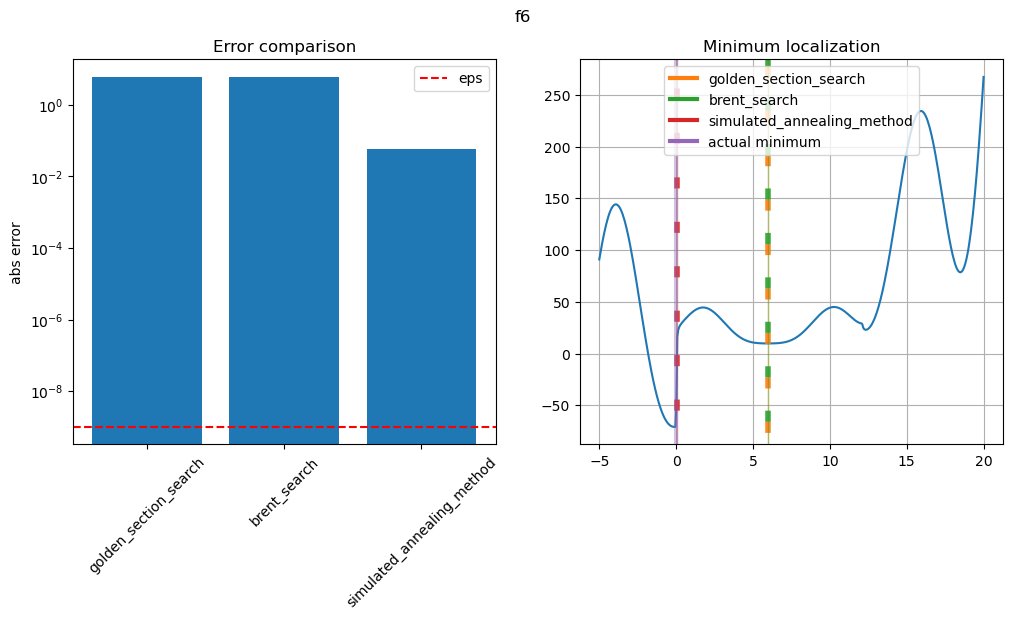

In [49]:
eps = 1e-9


def simulated_annealing_search(f, a, b, eps):
    return simulated_annealing_method(
        f,
        a,
        lambda x: np.random.normal() * (b - a) + x,
        lambda f_x, f_s, T: np.exp((f_x - f_s) / T),
        lambda q: q + 0.0001,
        info=False,
    )


search_methods = (
    (golden_section_search, "golden_section_search"),
    (brent_search, "brent_search"),
    (simulated_annealing_search, "simulated_annealing_method"),
)
g = dict()
# abs error for test and method
for test in tests:
    f, a, b, test_name = test
    for method in search_methods:
        optimize, method_name = method
        try:
            minx = optimize(f, a, b, eps)
        except:
            minx = optimize(f, a + eps, b - eps, eps)
        # print(minx)
        error = np.abs(minx - 0)
        g.setdefault(test_name, dict())[method_name] = error


figsize = (12, 5)
k = 0
for test_name, d in g.items():
    items = d.items()
    plt.figure(figsize=figsize)
    plt.suptitle(test_name)
    plt.subplot(121)
    plt.title("Error comparison")

    plt.bar(*zip(*items))
    plt.yscale("log")
    plt.ylabel("abs error")
    plt.xticks(rotation=45)
    plt.axhline(eps, linestyle="--", color="red", label="eps")
    plt.legend()
    plt.subplot(122)
    plt.title("Minimum localization")
    test = tests[k]
    k += 1
    f, a, b, s = test
    x = np.linspace(a, b, num=400)
    y = [f(i) for i in x]
    plt.plot(x, y)
    q = 0
    q_sz = len(items)
    dash_len = 2
    for method_name, e in items:
        # get color
        q += 1
        # adjust dashes
        (c,) = plt.plot([], [], label=method_name, alpha=1, lw=3)
        plt.axvline(e, color=c.get_color(), alpha=0.4, lw=1)
        plt.axvline(
            e,
            dashes=[0.0, q * dash_len, dash_len, (q_sz - q) * dash_len],
            color=c.get_color(),
            alpha=0.9,
            lw=4,
        )
    q += 1
    (c,) = plt.plot([], [], label="actual minimum", alpha=1, lw=3)
    plt.axvline(0, color=c.get_color(), alpha=0.4, lw=3)
    plt.legend(loc=9)
    plt.grid(True)
    plt.show()

Explore how the method works depending on selecting the "cooling" function.


/tmp/ipykernel_43873/3550262711.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  c = plt.scatter([], [], cmap="cool")
/tmp/ipykernel_43873/3550262711.py:11: RuntimeWarning: overflow encountered in exp
  lambda f_x, f_s, T: np.exp((f_x - f_s) / T),


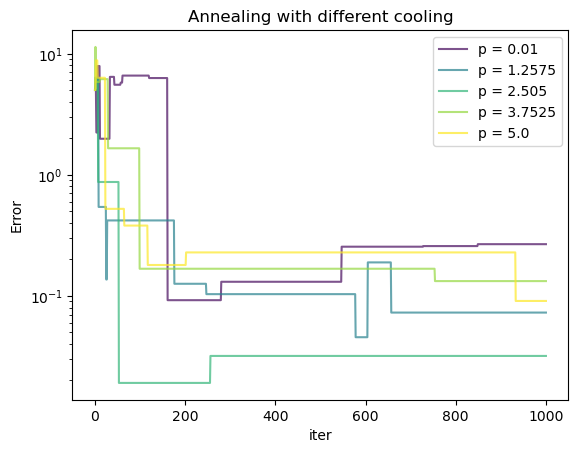

In [50]:
for p in np.linspace(0.01, 5, 5):
    (
        best_x,
        iters,
        calls,
        trajectory,
    ) = simulated_annealing_method(
        f,
        a,
        lambda x: np.random.normal() * (b - a) + x,
        lambda f_x, f_s, T: np.exp((f_x - f_s) / T),
        lambda q: (q + 0.0001) ** p,
        info=True,
    )
    c = plt.scatter([], [], cmap="cool")
    col = c.get_cmap()((p / 5.001) ** 0.6)
    plt.semilogy(
        list(range(iters + 1)),
        np.abs(trajectory),
        color=col,
        alpha=0.7,
        label=f"p = {p}",
    )
plt.title("Annealing with different cooling")
plt.xlabel("iter")
plt.ylabel("Error")
plt.legend()

#### 4
For the SGD method, compare with gradient and quasi-Newton methods for the problem of finding coefficients nonlinear regression.

In [51]:
@nb.njit
def f_a(x: np.ndarray, p: np.ndarray):
    return np.sin(x + p[0]) + np.cos(x * 2 + p[1])


@nb.njit
def f_b(x: np.ndarray, p: np.ndarray):
    return 10 * np.cos(np.exp(x) * 0.01) * p[0] + 2 * np.sin(p[1])

In [52]:
def gauss_newton_method(
    f: Callable[[float, np.ndarray], float],
    p0: np.ndarray,
    x: np.ndarray,
    y: np.ndarray,
    eps: float,
    max_it: int = 1000,
    info: bool = False,
) -> np.ndarray:
    assert f(x[0], p0) is not None
    assert x.shape[0] > p0.shape[0]
    assert x.shape[0] == y.shape[0]
    iters = 0
    calls = 0
    grad_calls = 0
    trajectory = []

    p = p0
    se_prev = np.inf
    for k in range(max_it):
        trajectory.append(p.copy())
        iters += 1
        calls += 1
        r = f(x, p) - y

        def fp(p):
            return f(x, p) - y

        grad_calls += 1
        J = np.array(grad(fp, p)).T
        # print(grad(fp,p))

        p = p - np.linalg.pinv(J.T @ J) @ J.T @ r
        se = np.sum(r**2)
        # print(f" {k}: SE {se}")
        diff = np.abs(se_prev**0.5 - se**0.5)
        if diff < eps:
            break
        se_prev = se

    trajectory.append(p.copy())
    if info:
        return p, iters, calls, grad_calls, trajectory
    else:
        return p

$\sin(x+\alpha)+\cos(x^2+\beta)$

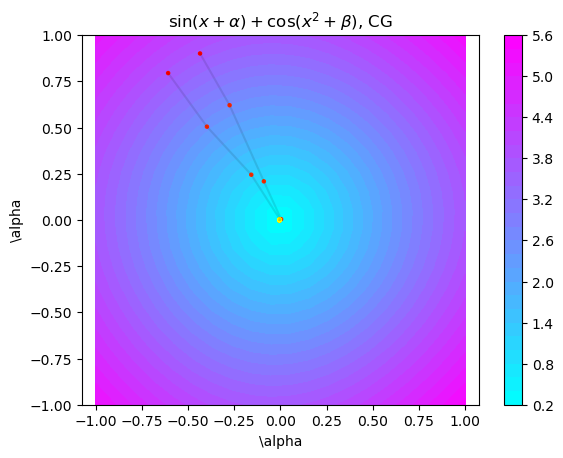

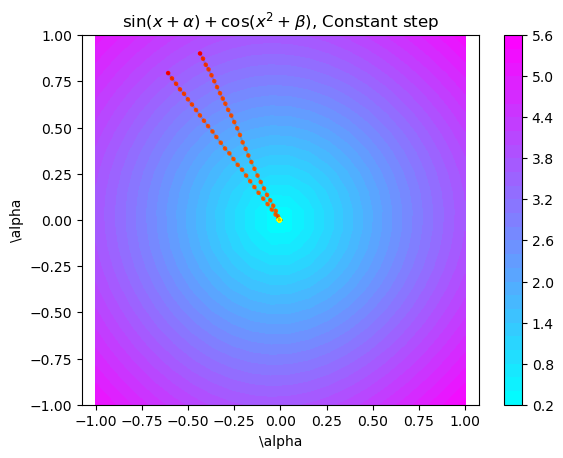

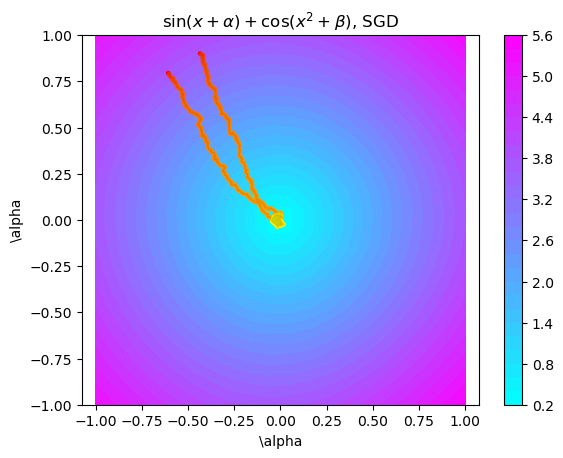

eps  CG (accuracy)  CG (iters)  CG (calls)  CG (grads)  \
0   1.000000e-01       0.072401           5          11           8   
1   3.359818e-02       0.018826           3          15           5   
2   1.128838e-02       0.009865           3          21           5   
3   3.792690e-03       0.003689           5          45           8   
4   1.274275e-03       0.004329        2000       24000        3000   
5   4.281332e-04       0.004533        2000       28000        3000   
6   1.438450e-04       0.004508        2000       32000        3000   
7   4.832930e-05       0.004515        2000       36000        3000   
8   1.623777e-05       0.004522        2000       42000        3000   
9   5.455595e-06       0.004521        2000       46000        3000   
10  1.832981e-06       0.004521        2000       50000        3000   
11  6.158482e-07       0.004521        2000       54000        3000   
12  2.069138e-07       0.004521        2000       60000        3000   
13  6.951928e-08       0.004521        2000       64000        3000   
14  2.335721e-08       0.004521        2000       68000        3000   
15  7.847600e-09       0.004521        2000       72000        3000   
16  2.636651e-09       0.004521        2000       78000        3000   
17  8.858668e-10       0.004521        2000       82000        3000   
18  2.976351e-10       0.004521        2000       86000        3000   
19  1.000000e-10       0.004521        2000       92000        3000   

    Constant step (accuracy)  Constant step (iters)  Constant step (calls)  \
0                   0.079267                     25                      0   
1                   0.019256                     27                      0   
2                   0.005776                     28                      0   
3                   0.003218                     30                      0   
4                   0.006096                   1000                      0   
5                   0.006096                   1000                      0   
6                   0.006096                   1000                      0   
7                   0.006096                   1000                      0   
8                   0.006096                   1000                      0   
9                   0.006096                   1000                      0   
10                  0.006096                   1000                      0   
11                  0.006096                   1000                      0   
12                  0.006096                   1000                      0   
13                  0.006096                   1000                      0   
14                  0.006096                   1000                      0   
15                  0.006096                   1000                      0   
16                  0.006096                   1000                      0   
17                  0.006096                   1000                      0   
18                  0.006096                   1000                      0   
19                  0.006096                   1000                      0   

    Constant step (grads)  SGD (accuracy)  SGD (iters)  SGD (calls)  \
0                      25        0.024880         1000        12000   
1                      27        0.029683         1000        12000   
2                      28        0.024057         1000        12000   
3                      30        0.015348         1000        12000   
4                    1000        0.023272         1000        12000   
5                    1000        0.020815         1000        12000   
6                    1000        0.026524         1000        12000   
7                    1000        0.025252         1000        12000   
8                    1000        0.019343         1000        12000   
9                    1000        0.014475         1000        12000   
10                   1000        0.022187         1000        12000   
11                   1000     

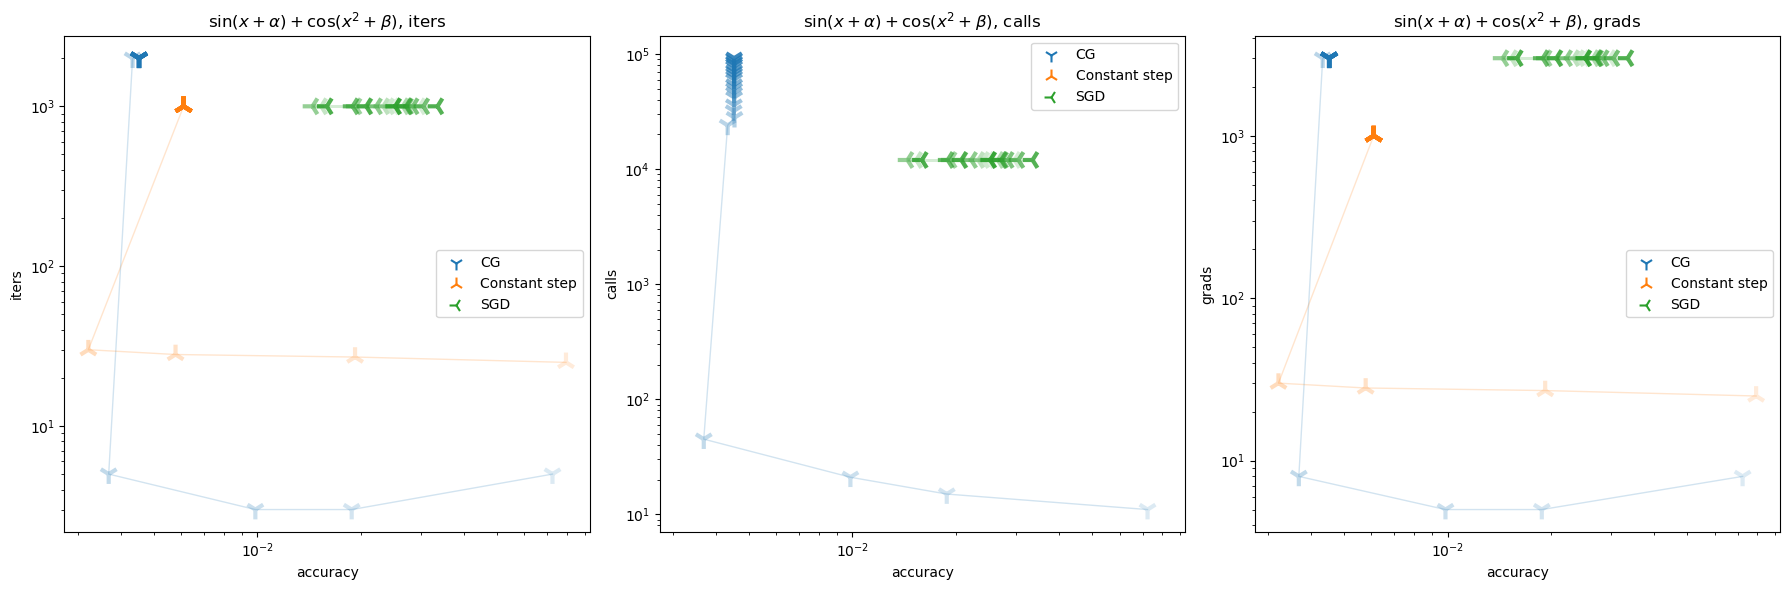

$10\cos(0.01\exp(x)))*\alpha+2\sin(\beta)$

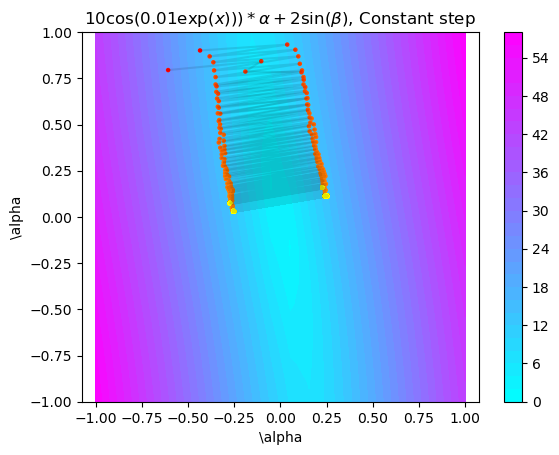

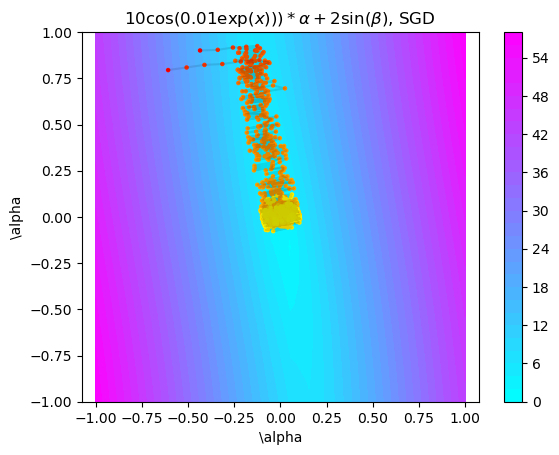

eps  CG (accuracy)  CG (iters)  CG (calls)  CG (grads)  \
0   1.000000e-01       2.268302        2000        4000        3000   
1   3.359818e-02       0.030783          80         400         120   
2   1.128838e-02       0.010077         544        3808         816   
3   3.792690e-03       0.087356        2000       18000        3000   
4   1.274275e-03       0.027350        2000       24000        3000   
5   4.281332e-04       0.015865        2000       28000        3000   
6   1.438450e-04       0.015292        2000       32000        3000   
7   4.832930e-05       0.015005        2000       36000        3000   
8   1.623777e-05       0.015094        2000       42000        3000   
9   5.455595e-06       0.015121        2000       46000        3000   
10  1.832981e-06       0.015123        2000       50000        3000   
11  6.158482e-07       0.015134        2000       54000        3000   
12  2.069138e-07       0.015133        2000       60000        3000   
13  6.951928e-08       0.015133        2000       64000        3000   
14  2.335721e-08       0.015133        2000       68000        3000   
15  7.847600e-09       0.015133        2000       72000        3000   
16  2.636651e-09       0.015133        2000       78000        3000   
17  8.858668e-10       0.015133        2000       82000        3000   
18  2.976351e-10       0.015133        2000       86000        3000   
19  1.000000e-10       0.015133        2000       92000        3000   

    Constant step (accuracy)  Constant step (iters)  Constant step (calls)  \
0                    0.26755                   1000                      0   
1                    0.26755                   1000                      0   
2                    0.26755                   1000                      0   
3                    0.26755                   1000                      0   
4                    0.26755                   1000                      0   
5                    0.26755                   1000                      0   
6                    0.26755                   1000                      0   
7                    0.26755                   1000                      0   
8                    0.26755                   1000                      0   
9                    0.26755                   1000                      0   
10                   0.26755                   1000                      0   
11                   0.26755                   1000                      0   
12                   0.26755                   1000                      0   
13                   0.26755                   1000                      0   
14                   0.26755                   1000                      0   
15                   0.26755                   1000                      0   
16                   0.26755                   1000                      0   
17                   0.26755                   1000                      0   
18                   0.26755                   1000                      0   
19                   0.26755                   1000                      0   

    Constant step (grads)  SGD (accuracy)  SGD (iters)  SGD (calls)  \
0                    1000        0.068230         1000        12000   
1                    1000        0.040812         1000        12000   
2                    1000        0.067994         1000        12000   
3                    1000        0.061052         1000        12000   
4                    1000        0.097157         1000        12000   
5                    1000        0.038051         1000        12000   
6                    1000        0.052601         1000        12000   
7                    1000        0.083374         1000        12000   
8                    1000        0.054272         1000        12000   
9                    1000        0.050145         1000        12000   
10                   1000        0.064651         1000        12000   
11                   1000     

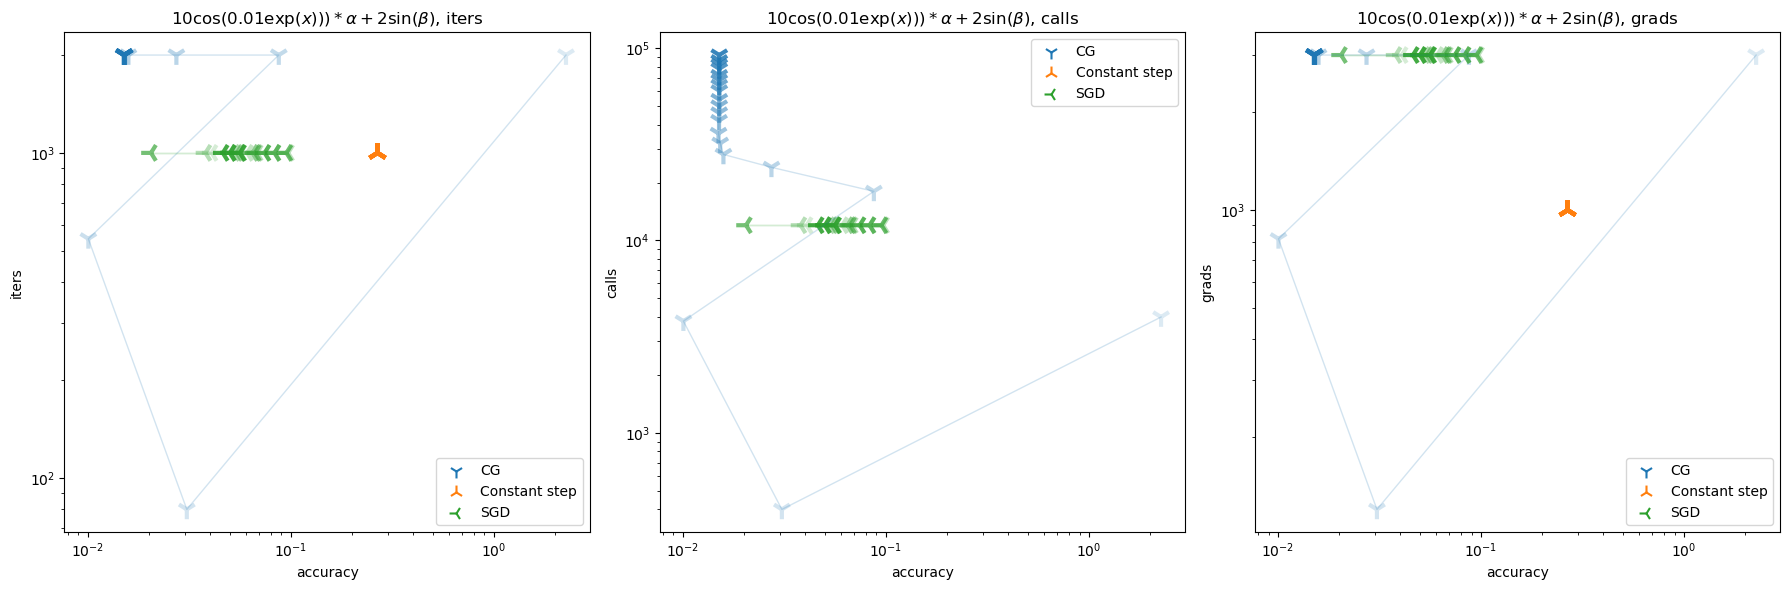

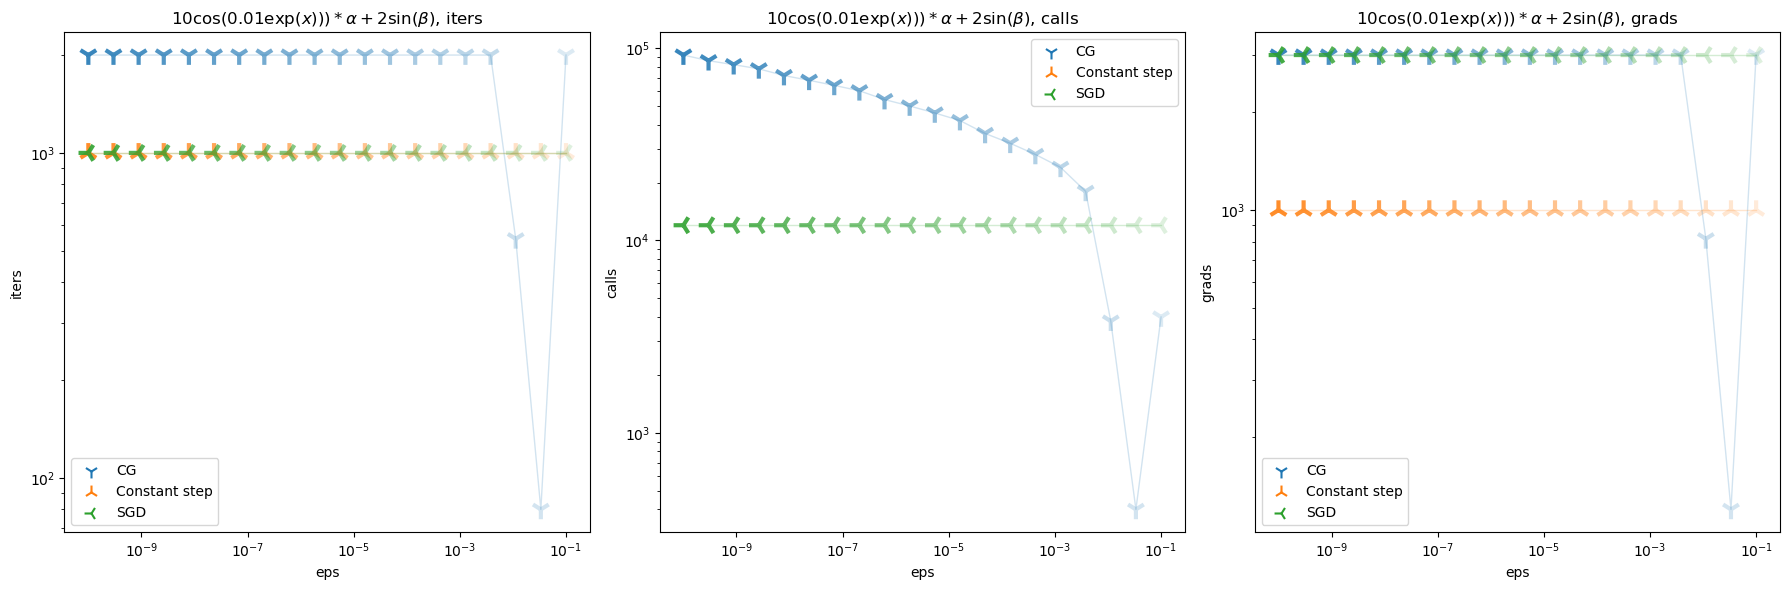

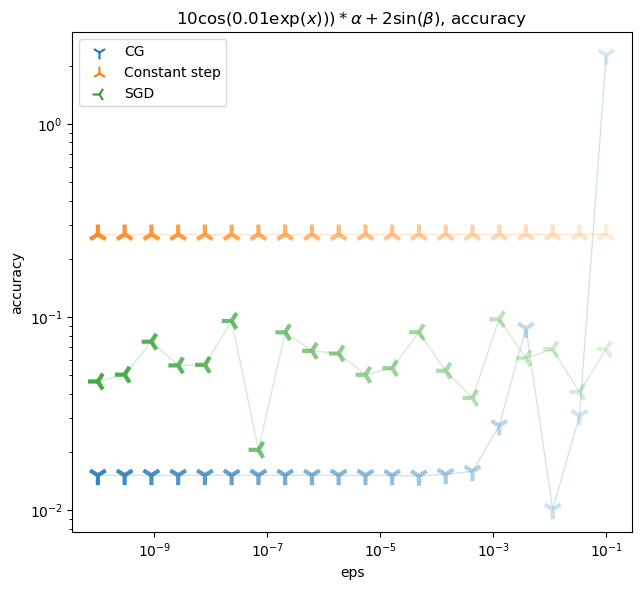

In [53]:
functions = [
    (f_a, r"$\sin(x+\alpha)+\cos(x^2+\beta)$"),
    (f_b, r"$10\cos(0.01\exp(x)))*\alpha+2\sin(\beta)$"),
]
methods = [
    (conjugate_gradient, "CG"),
    (gd_constant_step, "Constant step"),
    (sgd, "SGD"),
]


def make_tables(
    functions: list[tuple[Callable, str]],
    methods: list[tuple[Callable, str]],
    contour: bool = False,
    plot_tables: bool = False,
):
    num_of_random_points = 2
    radius = 1
    n_countour_points = 20
    levels = 30
    EPS = np.logspace(-1, -10, 20)
    xlim = [-1, 1]
    ylim = [-1, 1]
    random_points = [
        np.array(
            [
                np.cos(random_alpha * 2 * np.pi) * radius + (xlim[1] + xlim[0]) / 2,
                np.sin(random_alpha * 2 * np.pi) * radius + (ylim[1] + ylim[0]) / 2,
            ]
        )
        for random_alpha in np.random.random(num_of_random_points)
    ]
    x = np.linspace(-10, 10, 30)
    noise = np.random.normal(x.shape) * 0.001
    for f, f_name in functions:
        y = f(x, np.array([0.0, 0.0])) + noise
        print()
        print()
        display(Markdown(f_name))
        data = dict()
        data["eps"] = EPS
        for method, method_name in methods:

            def fp(p):
                return np.sum((f(x, p) - y) ** 2) ** 0.5

            def plot_contours():
                plt.title(f_name + ", " + method_name)
                plt.xlabel(r"\alpha")
                plt.ylabel(r"\alpha")
                xl = np.linspace(xlim[0], xlim[1], n_countour_points)
                yl = np.linspace(ylim[0], ylim[1], n_countour_points)
                xw, yw = np.meshgrid(xl, yl)
                z = 0 * xw * yw
                for qx, xp in enumerate(xl):
                    for qy, yp in enumerate(yl):
                        p = np.array([xp, yp])
                        # print(p)
                        z[qy, qx] = fp(p)
                # plt.grid()
                plt.axis("equal")
                if contour:
                    plt.contour(xw, yw, z, levels=levels, cmap="cool")
                else:
                    plt.contourf(xw, yw, z, levels=levels, cmap="cool")
                plt.colorbar()

            plot_contours()
            acc_total, iters_total, calls_total, grad_total = [], [], [], []
            for ideps, eps in enumerate(EPS):
                acc_multipoint, iters_multipoint, calls_multipoint, grad_multipoint = (
                    [],
                    [],
                    [],
                    [],
                )
                for point in random_points:
                    # y = f(x, p) + noise

                    # solve
                    p = point.copy()
                    if method_name in {"CG", "Constant step"}:
                        result, iters, calls, grad_calls, trajectory = method(
                            lambda p: np.sum((f(x, p) - y) ** 2) ** 0.5,
                            p,
                            eps=eps,
                            info=True,
                        )
                    elif method_name in {"GN"}:
                        result, iters, calls, grad_calls, trajectory = method(
                            f, p, x, y, eps=eps, info=True
                        )
                    elif method_name in {"SGD"}:
                        result, iters, calls, grad_calls, trajectory = method(
                            f,
                            p,
                            x,
                            y,
                            batch_size=max(1, int(len(y) / 10)),
                            info=True,
                            lr=0.01,
                        )
                    if ideps + 1 == len(EPS):
                        trajectory = np.array(trajectory)
                        xw, yw = trajectory.T[0], trajectory.T[1]
                        c = [(q / len(xw)) ** 0.25 for q in range(len(xw))]
                        plt.plot(xw, yw, color="black", alpha=0.1)
                        plt.scatter(xw, yw, s=5, c=c, cmap="autumn")
                    acc_multipoint.append(
                        np.linalg.norm(result - np.zeros_like(result))
                    )
                    iters_multipoint.append(iters)
                    calls_multipoint.append(calls)
                    grad_multipoint.append(grad_calls)
                acc_total.append(np.mean(acc_multipoint))
                iters_total.append(int(np.mean(iters_multipoint)))
                calls_total.append(int(np.mean(calls_multipoint)))
                grad_total.append(int(np.mean(grad_multipoint)))
            plt.xlim(xlim)
            plt.ylim(ylim)
            plt.show()
            data[method_name + " (accuracy)"] = acc_total
            data[method_name + " (iters)"] = iters_total
            data[method_name + " (calls)"] = calls_total
            data[method_name + " (grads)"] = grad_total
        data = pd.DataFrame(data)
        display(data)
        if plot_tables:
            # accuracy
            plt.figure(figsize=(18, 6))
            for plot_idx, plot_type in enumerate(["iters", "calls", "grads"]):
                plt.subplot(1, 3, plot_idx + 1)
                plt.title(f_name + ", " + plot_type)
                for method_id, (method, method_name) in enumerate(methods):
                    alpha = [
                        (0.2 + idx / len(data[method_name + f" ({plot_type})"])) / 1.3
                        for idx, d in enumerate(data[method_name + f" ({plot_type})"])
                    ]
                    (c,) = plt.plot([], [])
                    c = c.get_color()
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore")
                        plt.scatter(
                            [],
                            [],
                            label=method_name,
                            marker=str(method_id + 1),
                            s=100,
                            c=c,
                        )
                        plt.scatter(
                            data[method_name + " (accuracy)"],
                            data[method_name + f" ({plot_type})"],
                            marker=str(method_id + 1),
                            alpha=alpha,
                            s=200,
                            c=c,
                            lw=3,
                        )
                        plt.plot(
                            data[method_name + " (accuracy)"],
                            data[method_name + f" ({plot_type})"],
                            alpha=0.2,
                            c=c,
                            lw=1,
                        )
                        plt.xscale("log")
                        plt.yscale("log")
                plt.xlabel("accuracy")
                plt.ylabel(plot_type)
                plt.legend()
            plt.tight_layout()
            plt.show()
            # eps
            plt.figure(figsize=(18, 6))
            for plot_idx, plot_type in enumerate(["iters", "calls", "grads"]):
                plt.subplot(1, 3, plot_idx + 1)
                plt.title(f_name + ", " + plot_type)
                for method_id, (method, method_name) in enumerate(methods):
                    alpha = [
                        (0.2 + idx / len(data[method_name + f" ({plot_type})"])) / 1.3
                        for idx, d in enumerate(data[method_name + f" ({plot_type})"])
                    ]
                    (c,) = plt.plot([], [])
                    c = c.get_color()
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore")
                        plt.scatter(
                            [],
                            [],
                            label=method_name,
                            marker=str(method_id + 1),
                            s=100,
                            c=c,
                        )
                        plt.scatter(
                            data["eps"],
                            data[method_name + f" ({plot_type})"],
                            marker=str(method_id + 1),
                            alpha=alpha,
                            s=200,
                            c=c,
                            lw=3,
                        )
                        plt.plot(
                            data["eps"],
                            data[method_name + f" ({plot_type})"],
                            alpha=0.2,
                            c=c,
                            lw=1,
                        )
                        plt.xscale("log")
                        plt.yscale("log")
                plt.xlabel("eps")
                plt.ylabel(plot_type)
                plt.legend()
            plt.tight_layout()
            plt.show()
            # eps vs accuracy
            plt.figure(figsize=(18, 6))
            for plot_idx, plot_type in enumerate(["accuracy"]):
                plt.subplot(1, 3, plot_idx + 1)
                plt.title(f_name + ", " + plot_type)
                for method_id, (method, method_name) in enumerate(methods):
                    alpha = [
                        (0.2 + idx / len(data[method_name + f" ({plot_type})"])) / 1.3
                        for idx, d in enumerate(data[method_name + f" ({plot_type})"])
                    ]
                    (c,) = plt.plot([], [])
                    c = c.get_color()
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore")
                        plt.scatter(
                            [],
                            [],
                            label=method_name,
                            marker=str(method_id + 1),
                            s=100,
                            c=c,
                        )
                        plt.scatter(
                            data["eps"],
                            data[method_name + f" ({plot_type})"],
                            marker=str(method_id + 1),
                            alpha=alpha,
                            s=200,
                            c=c,
                            lw=3,
                        )
                        plt.plot(
                            data["eps"],
                            data[method_name + f" ({plot_type})"],
                            alpha=0.2,
                            c=c,
                            lw=1,
                        )
                        plt.xscale("log")
                        plt.yscale("log")
                plt.xlabel("eps")
                plt.ylabel(plot_type)
                plt.legend()
            plt.tight_layout()
            plt.show()


make_tables(functions, methods, plot_tables=True)

In [54]:
def grad(
    f: Callable[[np.ndarray], float],
    x: np.ndarray,
):
    Delta_f = np.zeros((len(x), len(f(x))), dtype=float)
    for k in range(len(x)):
        dx = np.zeros_like(x, dtype=float)
        dx[k] = np.finfo(float).eps * 10
        Delta_f[k] = (f(x + dx) - f(x - dx)) / (2 * np.linalg.norm(dx))
    return Delta_f

$\sin(x+\alpha)+\cos(x^2+\beta)$

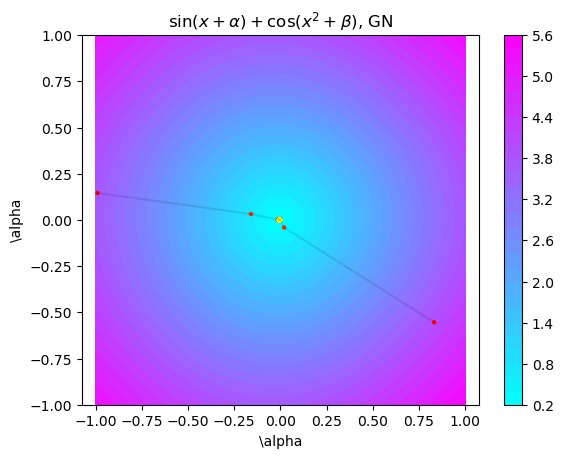

eps  GN (accuracy)  GN (iters)  GN (calls)  GN (grads)
0   1.000000e-01       0.004437           3           3           3
1   3.359818e-02       0.002566           4           4           4
2   1.128838e-02       0.002566           4           4           4
3   3.792690e-03       0.004098           4           4           4
4   1.274275e-03       0.004098           4           4           4
5   4.281332e-04       0.004364           5           5           5
6   1.438450e-04       0.004364           5           5           5
7   4.832930e-05       0.002631           9           9           9
8   1.623777e-05       0.002621          15          15          15
9   5.455595e-06       0.002439          18          18          18
10  1.832981e-06       0.002510          19          19          19
11  6.158482e-07       0.002793         136         136         136
12  2.069138e-07       0.002768         497         497         497
13  6.951928e-08       0.005873         649         649         649
14  2.335721e-08       0.006054        1000        1000        1000
15  7.847600e-09       0.006054        1000        1000        1000
16  2.636651e-09       0.006054        1000        1000        1000
17  8.858668e-10       0.006054        1000        1000        1000
18  2.976351e-10       0.006054        1000        1000        1000
19  1.000000e-10       0.006054        1000        1000        1000

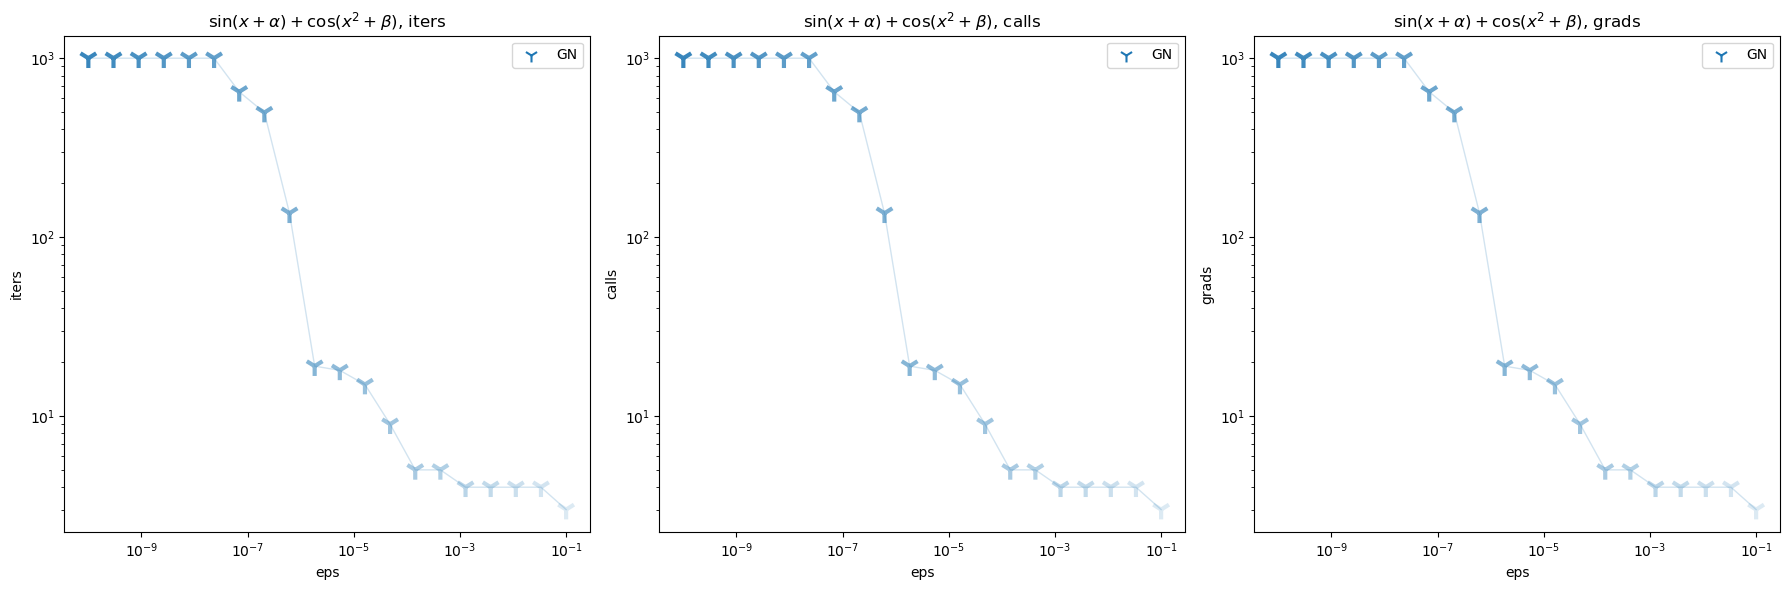

$10\cos(0.01\exp(x)))*\alpha+2\sin(\beta)$

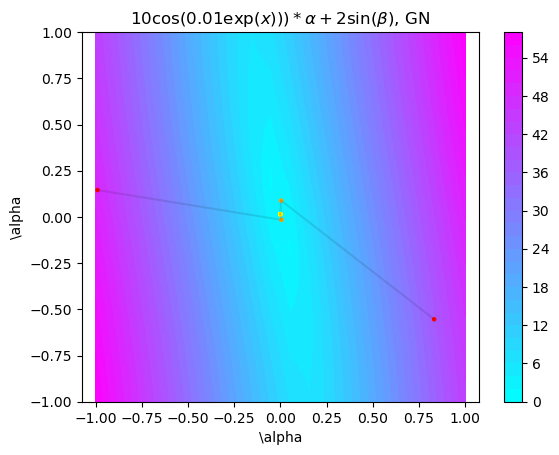

eps  GN (accuracy)  GN (iters)  GN (calls)  GN (grads)
0   1.000000e-01       0.015096           4           4           4
1   3.359818e-02       0.015096           4           4           4
2   1.128838e-02       0.015096           4           4           4
3   3.792690e-03       0.015096           4           4           4
4   1.274275e-03       0.015096           4           4           4
5   4.281332e-04       0.015096           4           4           4
6   1.438450e-04       0.015096           4           4           4
7   4.832930e-05       0.015096           4           4           4
8   1.623777e-05       0.015096           5           5           5
9   5.455595e-06       0.015096           5           5           5
10  1.832981e-06       0.015096           5           5           5
11  6.158482e-07       0.015096           5           5           5
12  2.069138e-07       0.015096           5           5           5
13  6.951928e-08       0.015096           5           5           5
14  2.335721e-08       0.015096           5           5           5
15  7.847600e-09       0.015096           5           5           5
16  2.636651e-09       0.015096           6           6           6
17  8.858668e-10       0.015096           6           6           6
18  2.976351e-10       0.015096           6           6           6
19  1.000000e-10       0.015096           6           6           6

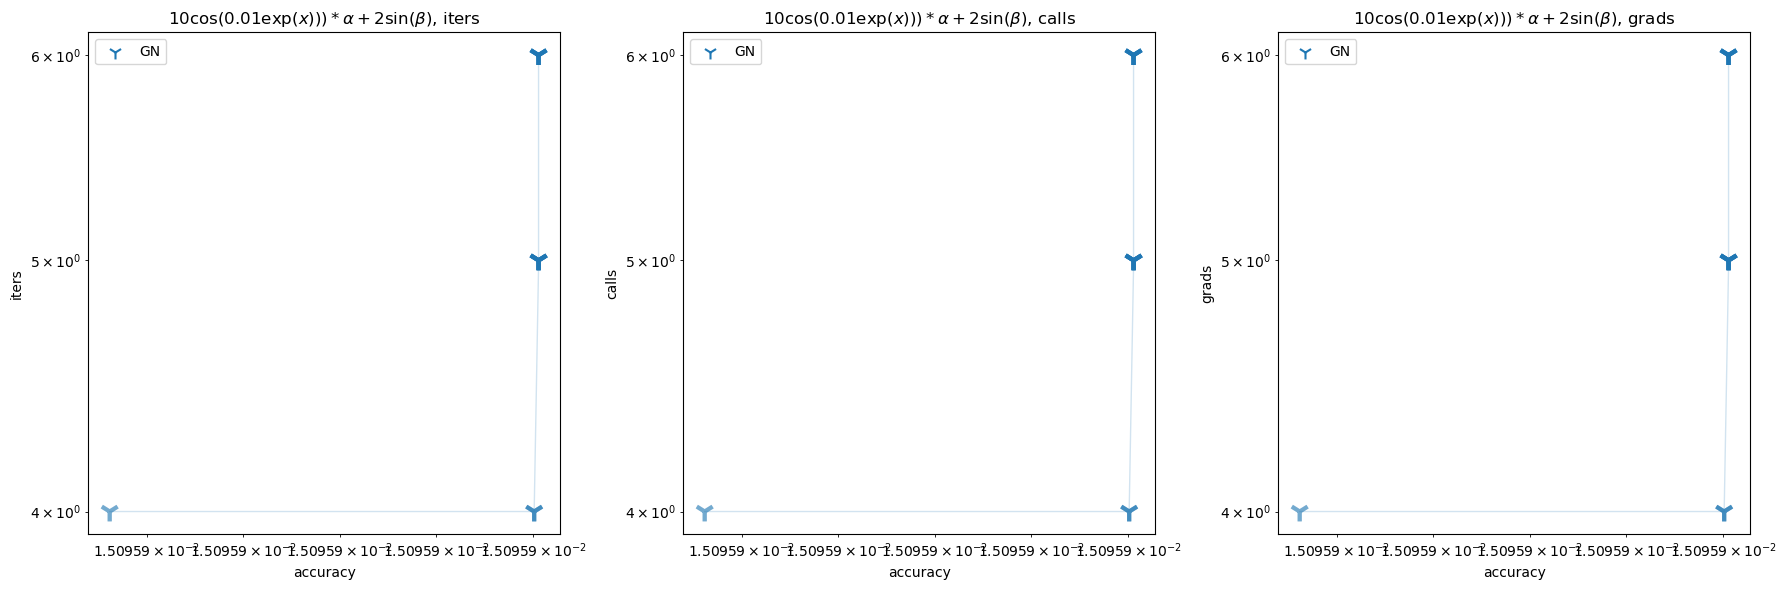

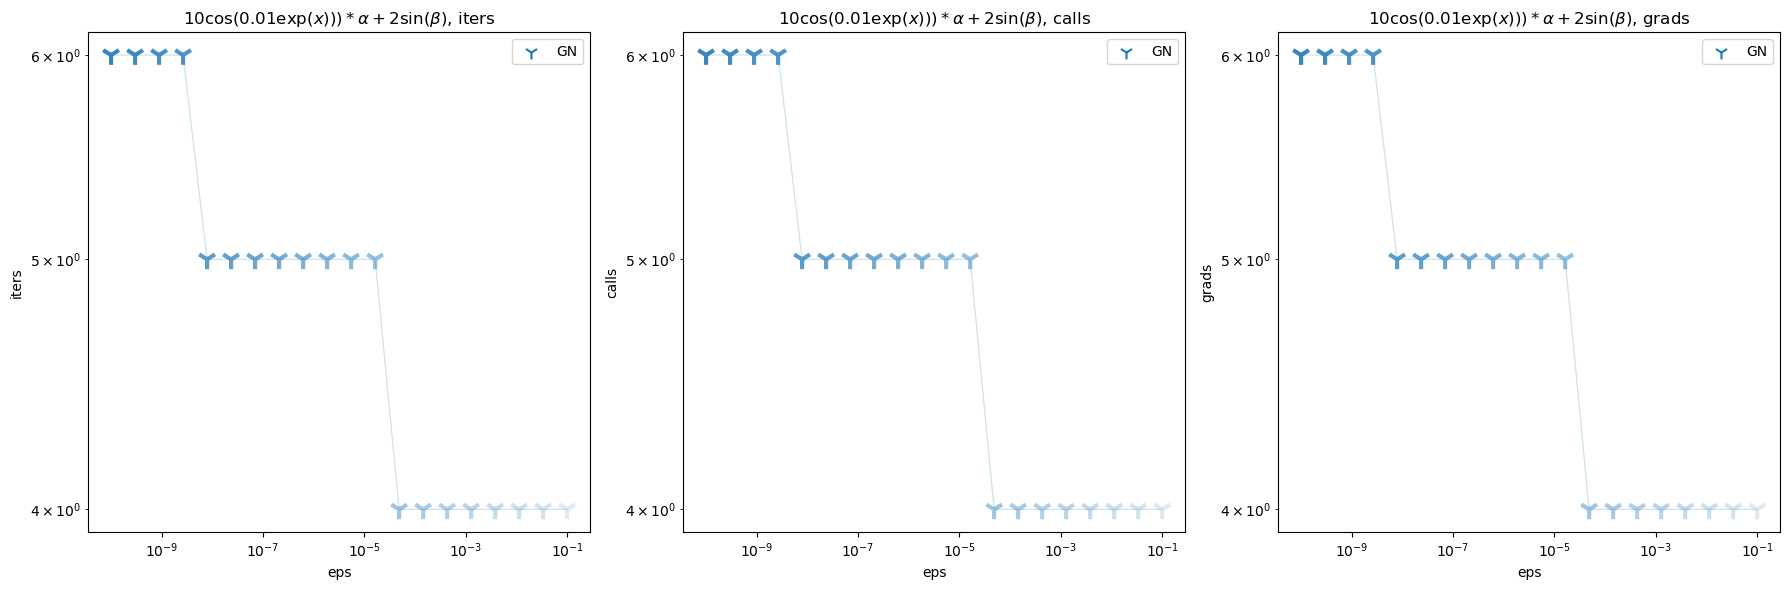

In [55]:
methods = [(gauss_newton_method, "GN")]
make_tables(functions, methods, plot_tables=True)

Find the most optimal batch size for the mini-batch SGD method.

In [58]:
def grad(
    f: Callable[[np.ndarray], float],
    x: np.ndarray,
):
    Delta_f = np.zeros(len(x), dtype=float)
    for k in range(len(x)):
        dx = np.zeros_like(x, dtype=float)
        dx[k] = np.finfo(float).eps * 10
        Delta_f[k] = (f(x + dx) - f(x - dx)) / (2 * np.linalg.norm(dx))
    return Delta_f

In [70]:
def test_sgd_batch_size():
    def f(x: float, k):
        assert len(k.shape) == 1
        assert k.shape[0] == 1
        return np.abs(x) * k[0]

    x = np.linspace(-100, 100, 100)
    # print(f(x,np.array([1.1])))
    batch_sizes = [int(q) for q in np.logspace(0, np.log10(len(x)), 5)]
    for batch_size in batch_sizes:
        y = f(x, np.array([2.0])) + np.random.random(x.shape)
        p, iters, calls, grad_calls, trajectory = sgd(
            f, np.array([1.0]), x, y, batch_size=batch_size,lr=1e-4, info=True
        )
        plt.semilogy(
            list(range(len(trajectory))),
            np.abs(np.array(trajectory) - 2.0),
            alpha=0.5,
            label=f"batch_size = {batch_size}",
        )
    plt.xlabel("iter")
    plt.ylabel("Error")
    plt.legend()


test_sgd_batch_size()

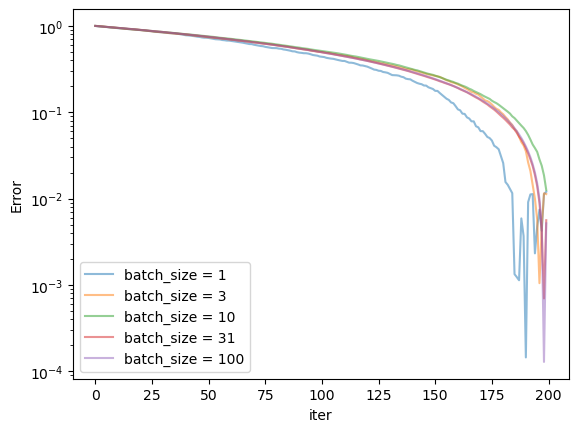

In [72]:
def test_sgd_batch_size():
    def f(x: float, k):
        assert len(k.shape) == 1
        assert k.shape[0] == 1
        return np.abs(x) * k[0]

    x = np.linspace(-100, 100, 100)
    # print(f(x,np.array([1.1])))
    batch_sizes = [int(q) for q in np.logspace(0, np.log10(len(x)), 5)]
    for batch_size in batch_sizes:
        y = f(x, np.array([2.0])) + np.random.random(x.shape)
        p, iters, calls, grad_calls, trajectory = sgd(
            f, np.array([1.0]), x, y, batch_size=batch_size,lr=1e-4, info=True
        )
        plt.semilogy(
            list(range(len(trajectory)))[:200],
            np.abs(np.array(trajectory) - 2.0)[:200],
            alpha=0.5,
            label=f"batch_size = {batch_size}",
        )
    plt.xlabel("iter")
    plt.ylabel("Error")
    plt.legend()


test_sgd_batch_size()